In [1]:
import torch
import torchvision
from torchvision import transforms
import numpy as np
import sys; sys.path.insert(0, '../')
import d2l_utils
%matplotlib inline

In [2]:
torch.manual_seed(0)
# torch.cuda.manual_seed_all(0)

torch.__version__               # PyTorch version
# torch.version.cuda              # Corresponding CUDA version
# torch.backends.cudnn.version()  # Corresponding cuDNN version
# torch.cuda.get_device_name(0)   # GPU type

'1.5.0'

torch.Size([16, 1, 32, 32]) torch.Size([16])


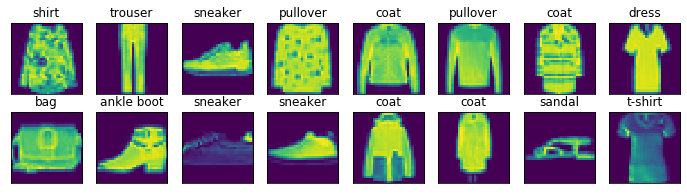

In [26]:
transform = transforms.Compose([
    # you can add other transformations in this list
    transforms.Resize((32,32)),
    transforms.ToTensor(),
])

imagenet_data = torchvision.datasets.FashionMNIST('path/to/imagenet_root/', transform=transform, download=True)
data_loader = torch.utils.data.DataLoader(imagenet_data,
                                          batch_size=16,
                                          shuffle=True,
                                          num_workers=4)
for X, y in data_loader:
    print(X.shape, y.shape)
    d2l_utils.show_images(X.squeeze(dim=1), 2, 8, get_fashion_mnist_labels(y))
    break

In [19]:
from matplotlib import pyplot as plt

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.imshow(img.numpy().reshape((28,28)))
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

array([<matplotlib.axes._subplots.AxesSubplot object at 0x121c3b910>,
      dtype=object)

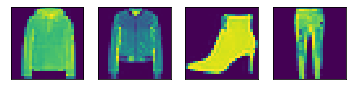

In [15]:
show_images(i[0], 1, 4)

In [18]:
i[0].squeeze(dim=1).shape

torch.Size([4, 28, 28])

In [ ]:
i[0].squeeze